# Method 3 : RL-Based method for Diplomacy with Reward Shaping and Recurrent Policy

This code implements an RL-based deception detector for Diplomacy conversations. The goal is to have an agent that, at each
timestep (i.e. for each message), observes a 769-dimensional vector composed of a DistilBERT [CLS] embedding (768 dims)
and a normalized game score delta and outputs an action: 0 for "Truth" and 1 for "Lie". The reward function
is shaped to penalize misclassifying lies more harshly than misclassifying truths.

To enhance code modularity and clarity, we divide the implementation into four classes:
  
  1. RLPreprocessor: Loads and validates conversations from JSONL files.
  2. RLConversationsDataset: Wraps a list of conversations and provides methods to instantiate a Gym-style environment
     for a random conversation.
  3. RLTrainer: Sets up and trains the RL agent (using RecurrentPPO with an LSTM-based policy) on the training data.
  4. RLEvaluator: Evaluates the trained agent on test conversations and prints overall metrics and a detailed classification report.

The overall functioning can be viewed in the flowchart below : 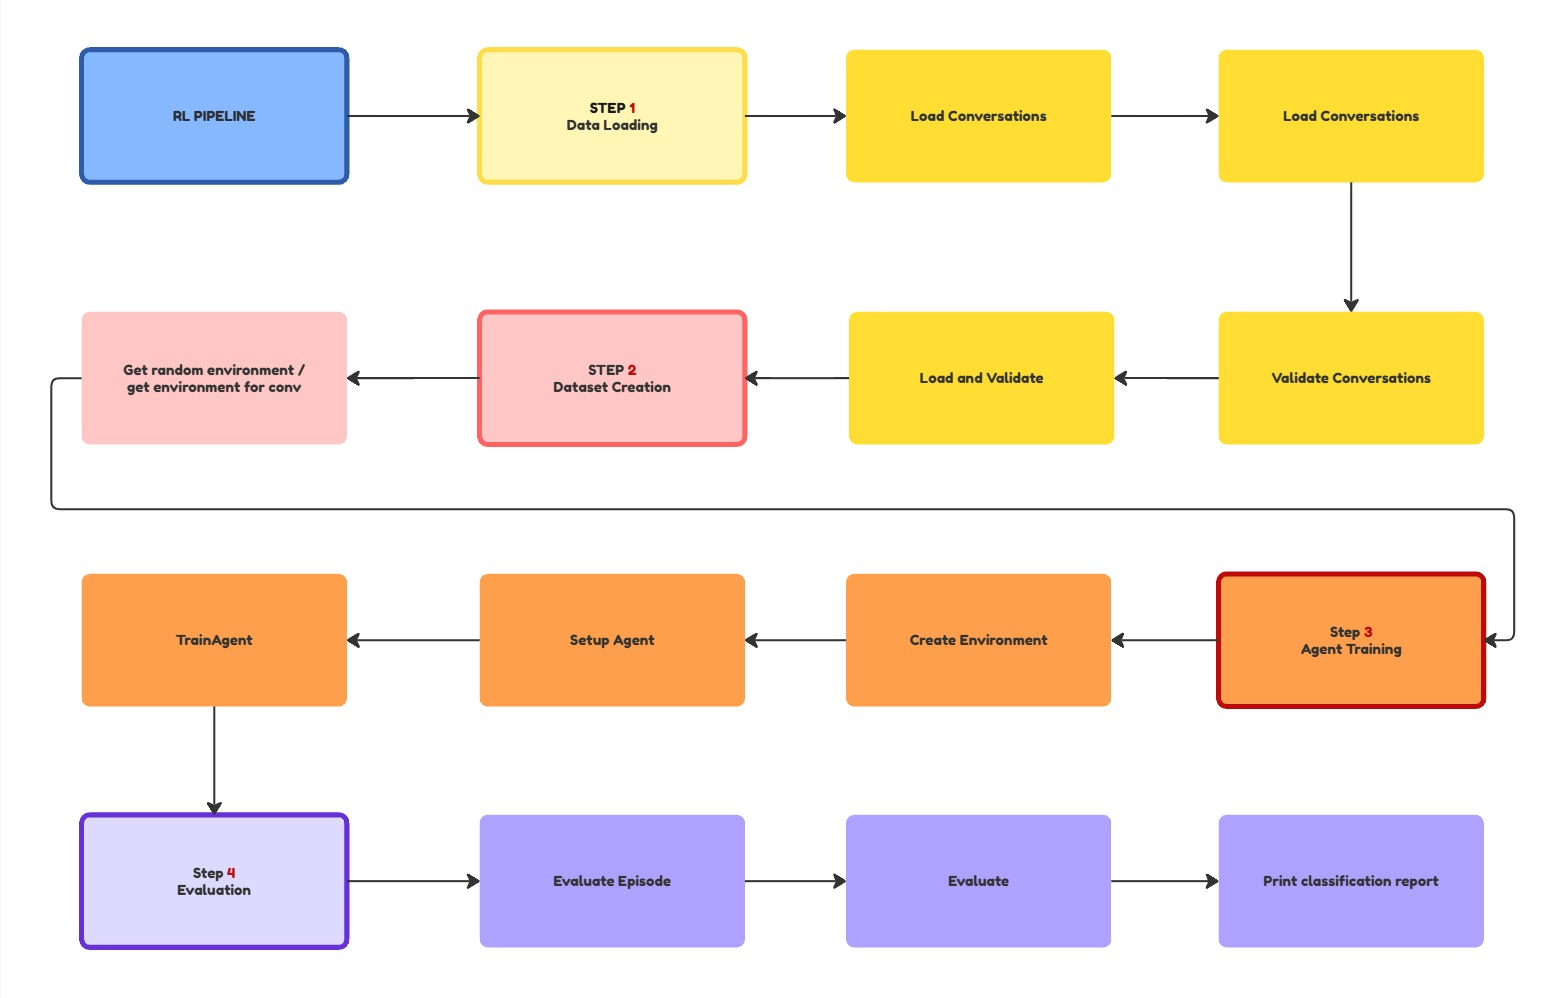
  

## Install Dependecies

In [ ]:
!pip install gym stable-baselines3 sb3-contrib torch torchvision transformers scikit-learn shimmy

In [13]:
import os, json, random, numpy as np
import gym
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
import torch.optim as optim
from transformers import DistilBertModel, DistilBertTokenizer
from sb3_contrib.ppo_recurrent import RecurrentPPO
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing of the dataset :
This implements a class which loads and validates conversation data from JSONL files. Following methods have used :
 - load_conversations: Load conversations from a given file path.
 - validate_conversation: Check if required fields exist.
 - load_and_validate: Combines loading and validation and return only valid conversation

In [3]:
class preprocessing_class:
    REQUIRED_FIELDS = ["messages", "sender_labels", "game_score_delta"]

    @staticmethod
    def load_conversations(filepath):
        convs = []
        with open(filepath, 'r', encoding='utf8') as f:
            for line in f:
                try:
                    conv = json.loads(line)
                    convs.append(conv)
                except Exception as e:
                    print(f"Error parsing line: {e}")
        return convs

    @staticmethod
    def validate_conversation(conv):
        for field in preprocessing_class.REQUIRED_FIELDS:
            if field not in conv or not conv.get(field): return False
        if len(conv["messages"]) == 0 or len(conv["sender_labels"]) == 0: return False
        return True

    @staticmethod
    def load_and_validate(filepaths):
        all_convs = []
        for path in filepaths:
            convs = preprocessing_class.load_conversations(path)
            valid_convs = [conv for conv in convs if preprocessing_class.validate_conversation(conv)]
            all_convs.extend(valid_convs)
        return all_convs

train_convs = preprocessing_class.load_and_validate(["train.jsonl"])
val_convs   = preprocessing_class.load_and_validate(["validation.jsonl"])
test_convs  = preprocessing_class.load_and_validate(["test.jsonl"])
print(f"Loaded {len(train_convs)} training, {len(val_convs)} validation, and {len(test_convs)} test conversations.")

Loaded 184 training, 20 validation, and 42 test conversations.


## Creating the RL environment :  
This implements the class which wraps a list of conversations and provides methods to create Gym environments for RL training/evaluation. Following methods were implemented
- get_random_env: Returns a DiplomacyEnv instance for a random conversation.
- get_env_for_conversation: Returns a DiplomacyEnv for a given conversation.
- get_all_envs: Returns a list of Gym environments for all conversations

In [4]:
class conversation_dataset:
    def __init__(self, conversations, deceptive_reward_factor=10):
        self.conversations = conversations
        self.deceptive_reward_factor = deceptive_reward_factor

    def get_random_env(self):
        conv = random.choice(self.conversations)
        return DiplomacyEnv([conv], deceptive_reward_factor=self.deceptive_reward_factor)

    def get_env_for_conversation(self, conv):
        return DiplomacyEnv([conv], deceptive_reward_factor=self.deceptive_reward_factor)

    def get_all_envs(self):
        return [DiplomacyEnv([conv], deceptive_reward_factor=self.deceptive_reward_factor) for conv in self.conversations]

## Custom Gym Environment (used by the RL agent)
This implemnets the gym environment which is used by the RL agent for deception detection in Diplomacy. Each episode corresponds to one conversation.
    
- Observation: 769-dimensional vector (768-dim DistilBERT embedding + 1-dim normalized game_score_delta).
- Action Space: Discrete(2) (0: Truth, 1: Lie).
- Reward: Shaped based on the message's true label.

In [5]:
class DiplomacyEnv(gym.Env):
    def __init__(self, conversations, deceptive_reward_factor=10):
        super(DiplomacyEnv, self).__init__()
        self.conversations = conversations
        self.deceptive_reward_factor = deceptive_reward_factor
        self.current_conv = None
        self.current_idx = 0
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(769,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)

    def reset(self):
        self.current_conv = random.choice(self.conversations)
        self.current_idx = 0
        return self._get_obs()

    def _get_obs(self):
        messages = self.current_conv.get("messages", [])
        diffs = self.current_conv.get("game_score_delta", [])
        if self.current_idx >= len(messages):
            return np.zeros(self.observation_space.shape, dtype=np.float32)
        current_text = messages[self.current_idx]
        emb = get_content_embedding(current_text)
        try:
            diff = float(diffs[self.current_idx])
        except:
            diff = 0.0
        diff_norm = diff / 18.0
        obs = torch.cat([emb, torch.tensor([diff_norm], dtype=torch.float)], dim=0)
        return obs.numpy().astype(np.float32)

    def step(self, action):
        messages = self.current_conv.get("messages", [])
        if self.current_idx >= len(messages):
            return np.zeros(self.observation_space.shape, dtype=np.float32), 0.0, True, {}
        try:
            true_label = int(not bool(self.current_conv["sender_labels"][self.current_idx]))
        except IndexError:
            true_label = 0
        if true_label == 1:
            reward = self.deceptive_reward_factor if action == 1 else -self.deceptive_reward_factor
        else:
            reward = 1.0 if action == 0 else -1.0
        info = {"true_label": true_label}
        self.current_idx += 1
        done = (self.current_idx >= len(messages))
        next_obs = self._get_obs() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return next_obs, reward, done, info

## Training of the RL agent
Here, we set up and trains an RL agent (using RecurrentPPO with the 'MlpLstmPolicy') on the training conversations.
    
- create_environment: Builds a single environment from a list of conversations.
- setup_agent: Instantiates the RecurrentPPO agent with the provided environment.
- train_agent: Trains the agent for a specified number of timesteps.


In [6]:
class Training_class:
    def __init__(self, conversations, deceptive_reward_factor=10):
        self.conversations = conversations
        self.deceptive_reward_factor = deceptive_reward_factor
        self.env = DiplomacyEnv(self.conversations, deceptive_reward_factor=self.deceptive_reward_factor)
        self.agent = None

    def create_environment(self):
        return DiplomacyEnv(self.conversations, deceptive_reward_factor=self.deceptive_reward_factor)

    def setup_agent(self, learning_rate=1e-4, n_steps=256, batch_size=64, gamma=0.99):
        self.agent = RecurrentPPO("MlpLstmPolicy", self.env, verbose=1,
                                  learning_rate=learning_rate, n_steps=n_steps,
                                  batch_size=batch_size, gamma=gamma)
        return self.agent

    def train_agent(self, total_timesteps=10000):
        if self.agent is None:
            self.setup_agent()
        self.agent.learn(total_timesteps=total_timesteps)
        return self.agent

    def save_agent(self, filepath):
        if self.agent is not None:
            self.agent.save(filepath)
            print(f"Agent saved to {filepath}")
        else:
            print("Agent is not trained yet; nothing to save.")

## Evaluation
Evaluates the trained RL agent on a set of test conversations and provides detailed metrics and reports.
- evaluate_episode: Runs one episode (one conversation) and returns the final prediction and true label.
- evaluate: Runs evaluation over multiple episodes and computes accuracy, macro F1, Lie F1.
- print_classification_report: Prints a detailed classification report.

In [7]:
class evaluation_class:
    def __init__(self, agent, conversations, default_reward_factor=10):
        self.agent = agent
        self.conversations = conversations
        self.default_reward_factor = default_reward_factor

    def evaluate_episode(self):
        conv = random.choice(self.conversations)
        reward_factor = self.default_reward_factor
        if hasattr(self.agent.env, "envs"):
            try:
                reward_factor = self.agent.env.envs[0].env.deceptive_reward_factor
            except AttributeError:
                reward_factor = self.default_reward_factor
        env_test = DiplomacyEnv([conv], deceptive_reward_factor=reward_factor)
        obs = env_test.reset()
        done = False
        final_action = None
        while not done:
            action, _ = self.agent.predict(obs, deterministic=True)
            final_action = action
            obs, reward, done, info = env_test.step(action)
        try:
            true_label = int(not bool(conv["sender_labels"][-1]))
        except IndexError:
            true_label = 0
        return true_label, final_action

    def evaluate(self, num_episodes=100):
        all_true, all_preds = [], []
        for _ in range(num_episodes):
            true_label, pred_label = self.evaluate_episode()
            all_true.append(true_label)
            all_preds.append(pred_label)
        return all_true, all_preds

    def print_classification_report(self, num_episodes=100):
        all_true, all_preds = self.evaluate(num_episodes=num_episodes)
        acc = accuracy_score(np.array(all_true), np.array(all_preds))
        macro_f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)
        lie_f1 = f1_score(all_true, all_preds, pos_label=1, zero_division=0)
        print(f"Evaluation over {num_episodes} episodes:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  Macro F1: {macro_f1:.4f}")
        print(f"  Lie F1:   {lie_f1:.4f}")

## Helper functions and Main call

In [12]:
content_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
content_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
content_model.to(device)
content_model.eval()

def get_content_embedding(text):
    inputs = content_tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = content_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0).cpu()

if __name__ == "__main__":
    print("Setting up and training the RL agent...")
    train_dataset = conversation_dataset(train_convs, deceptive_reward_factor=10)
    trainer = Training_class(train_convs, deceptive_reward_factor=10)
    trainer.setup_agent()
    trained_agent = trainer.train_agent(total_timesteps=10000)
    trainer.save_agent("rl_method.zip")

    print("Evaluating the RL agent on test conversations...")
    evaluator = evaluation_class(trained_agent, test_convs, default_reward_factor=10)
    evaluator.print_classification_report(num_episodes=100)


Setting up and training the RL agent...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 7.5      |
| time/              |          |
|    fps             | 137      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 256      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.5         |
|    ep_rew_mean          | 1.7          |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0013082898 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | 6.27e-05     |
|    learning_r

## Qualitative Analysis
For the qualitative analysis, provides a suite of methods for qualitative analysis of an RL-based deception detection agent in the Diplomacy task.This class includes methods for:
- Running and saving detailed episode transcripts.
- Plotting confusion matrices and other metrics.
- Visualizing per-episode statistics (e.g., reward and length).

In [15]:

class qualtitative_analysis:
    def __init__(self, agent, conversations, default_reward_factor=10):
        self.agent = agent
        self.conversations = conversations
        self.default_reward_factor = default_reward_factor

    def run_episode(self):
        conv = random.choice(self.conversations)
        reward_factor = self.default_reward_factor
        if hasattr(self.agent.env, "envs"):
            try:
                reward_factor = self.agent.env.envs[0].env.deceptive_reward_factor
            except AttributeError:
                reward_factor = self.default_reward_factor
        env = DiplomacyEnv([conv], deceptive_reward_factor=reward_factor)
        obs = env.reset()
        done = False
        episode_details = []
        final_action = None
        while not done:
            action, _ = self.agent.predict(obs, deterministic=True)
            final_action = action
            next_obs, reward, done, info = env.step(action)
            episode_details.append({
                "step": env.current_idx,
                "action": action,
                "reward": reward,
                "true_label": info.get("true_label", None)
            })
            obs = next_obs
        try:
            final_true_label = int(not bool(conv["sender_labels"][-1]))
        except IndexError:
            final_true_label = 0
        return episode_details, final_true_label, final_action

    def evaluate_episodes(self, num_episodes=100):
        all_true = []
        all_preds = []
        for _ in range(num_episodes):
            true_label, pred = self.evaluate_episode_final()
            all_true.append(true_label)
            all_preds.append(pred)
        return all_true, all_preds

    def evaluate_episode_final(self):
        _, true_label, final_action = self.run_episode()
        return true_label, final_action

    def plot_confusion_matrix(self, num_episodes=100):
        all_true, all_preds = self.evaluate_episodes(num_episodes=num_episodes)
        cm = confusion_matrix(all_true, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Truth", "Lie"], yticklabels=["Truth", "Lie"])
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.title(f"Confusion Matrix over {num_episodes} Episodes")
        plt.show()

    def plot_episode_statistics(self, num_episodes=20):
        episode_lengths = []
        cumulative_rewards = []
        for _ in range(num_episodes):
            details, _, _ = self.run_episode()
            episode_lengths.append(len(details))
            cumulative_rewards.append(sum([step["reward"] for step in details]))
        fig, ax1 = plt.subplots(figsize=(8, 4))
        color = "tab:blue"
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Episode Length", color=color)
        ax1.plot(range(num_episodes), episode_lengths, marker="o", color=color, label="Episode Length")
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()
        color = "tab:red"
        ax2.set_ylabel("Cumulative Reward", color=color)
        ax2.plot(range(num_episodes), cumulative_rewards, marker="s", color=color, label="Cumulative Reward")
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        plt.title("Episode Statistics: Length and Cumulative Reward")
        plt.show()

    def print_sample_episode(self):
        details, true_label, final_action = self.run_episode()
        print("Sample Episode Transcript:")
        for step in details:
            print(f"Step {step['step']:3d}: Action = {step['action']}, Reward = {step['reward']:.2f}, True Label = {step['true_label']}")
        print(f"\nFinal True Label: {true_label}, Final Predicted Action: {final_action}")


In [16]:
analyzer = qualtitative_analysis(trained_agent, test_convs, default_reward_factor=10)
analyzer.print_sample_episode()

Sample Episode Transcript:
Step   1: Action = 0, Reward = 1.00, True Label = 0
Step   2: Action = 0, Reward = 1.00, True Label = 0
Step   3: Action = 0, Reward = 1.00, True Label = 0
Step   4: Action = 0, Reward = 1.00, True Label = 0
Step   5: Action = 0, Reward = 1.00, True Label = 0
Step   6: Action = 0, Reward = 1.00, True Label = 0
Step   7: Action = 0, Reward = -10.00, True Label = 1
Step   8: Action = 0, Reward = -10.00, True Label = 1
Step   9: Action = 0, Reward = -10.00, True Label = 1
Step  10: Action = 0, Reward = 1.00, True Label = 0
Step  11: Action = 0, Reward = 1.00, True Label = 0
Step  12: Action = 0, Reward = 1.00, True Label = 0
Step  13: Action = 0, Reward = 1.00, True Label = 0
Step  14: Action = 0, Reward = 1.00, True Label = 0
Step  15: Action = 0, Reward = 1.00, True Label = 0
Step  16: Action = 0, Reward = 1.00, True Label = 0
Step  17: Action = 0, Reward = 1.00, True Label = 0
Step  18: Action = 0, Reward = 1.00, True Label = 0
Step  19: Action = 0, Reward = 

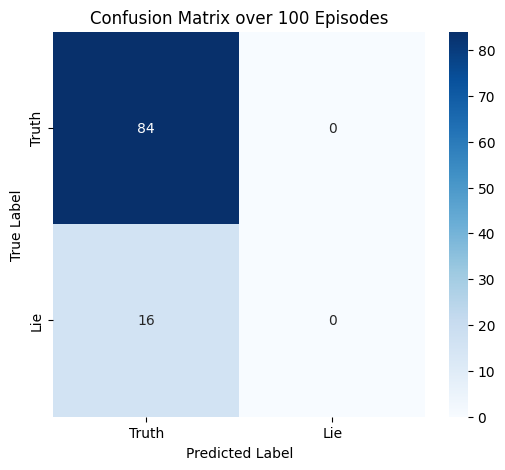

In [17]:
analyzer.plot_confusion_matrix(num_episodes=100)

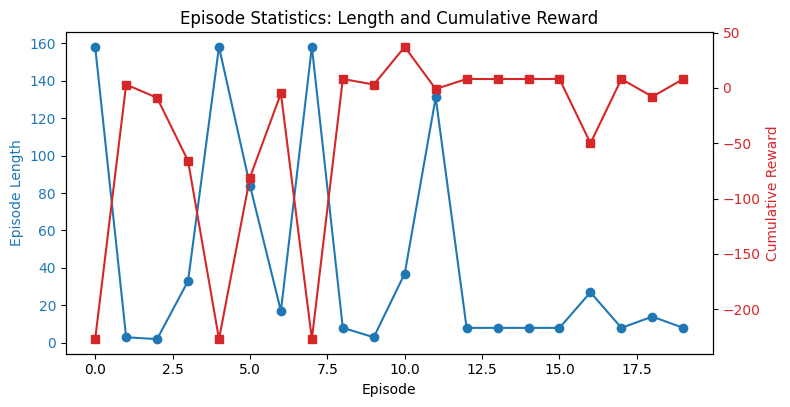

In [18]:
analyzer.plot_episode_statistics(num_episodes=20)